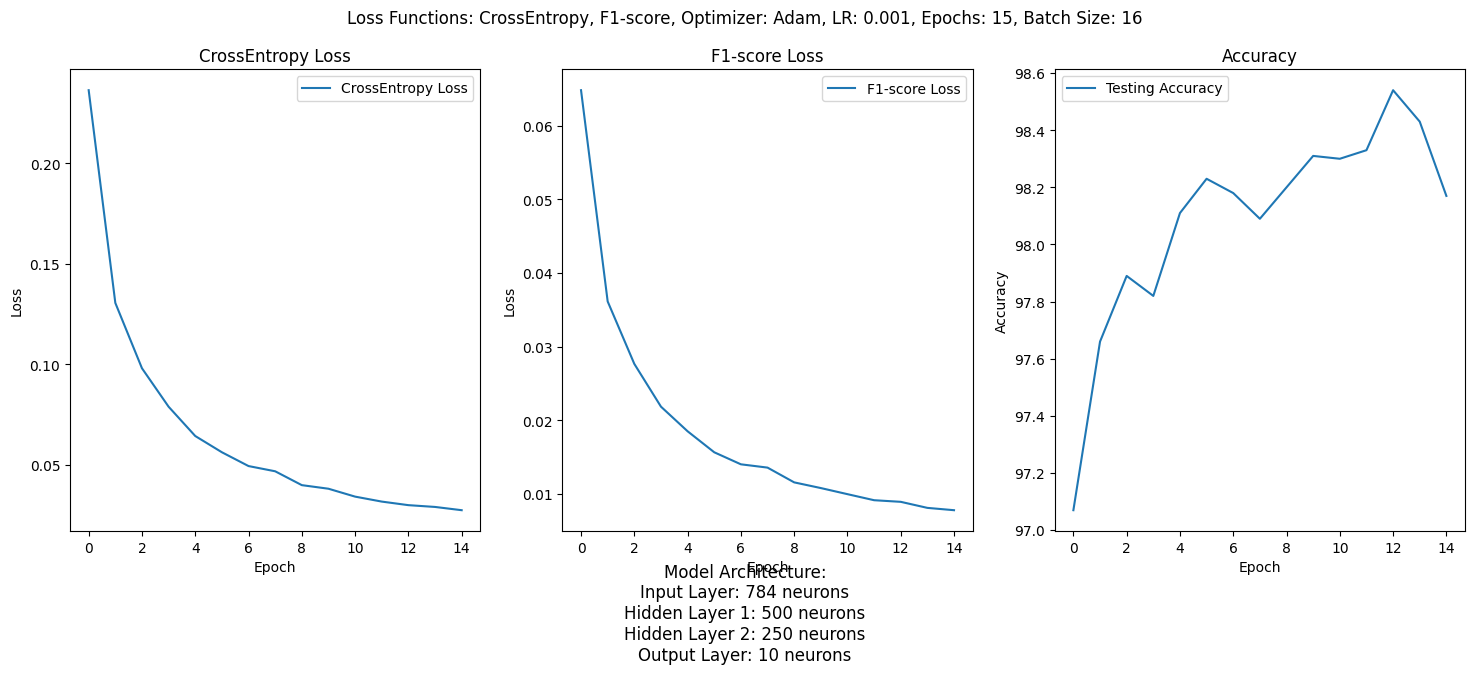

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from IPython.display import clear_output

# Установка гиперпараметров
input_size = 784  # 28x28
hidden_size1 = 500
hidden_size2 = 250
num_classes = 10
num_epochs = 15
batch_size = 16
learning_rate = 0.001

# Загрузка и нормализация данных MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Определение модели
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        return out

model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes)

# Определение функции потерь и оптимизатора
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Инициализация для графиков
loss_ce_list = []
loss_f1_list = []
accuracy_list = []

# Функция для обновления и сохранения графиков
def update_plots(loss_ce_list, loss_f1_list, accuracy_list, epoch, save_path='training_progress.png'):
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    
    # График функции потерь CrossEntropy
    plt.subplot(1, 3, 1)
    plt.plot(loss_ce_list, label='CrossEntropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CrossEntropy Loss')
    plt.legend()
    
    # График функции потерь F1-score
    plt.subplot(1, 3, 2)
    plt.plot(loss_f1_list, label='F1-score Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('F1-score Loss')
    plt.legend()
    
    # График точности
    plt.subplot(1, 3, 3)
    plt.plot(accuracy_list, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    # Добавление информации о модели
    plt.suptitle(f'Loss Functions: CrossEntropy, F1-score, Optimizer: Adam, LR: {learning_rate}, Epochs: {num_epochs}, Batch Size: {batch_size}')
    
    # Информация о слоях модели
    model_info = (
        f"Model Architecture:\n"
        f"Input Layer: {input_size} neurons\n"
        f"Hidden Layer 1: {hidden_size1} neurons\n"
        f"Hidden Layer 2: {hidden_size2} neurons\n"
        f"Output Layer: {num_classes} neurons"
    )
    
    plt.figtext(0.5, -0.1, model_info, wrap=True, horizontalalignment='center', fontsize=12)
    
    # Сохранение графиков в файл
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Функция для вычисления F1-score как потери
def f1_loss(outputs, labels):
    outputs = torch.argmax(outputs, dim=1)
    f1 = f1_score(labels.cpu().numpy(), outputs.cpu().numpy(), average='weighted')
    return 1 - f1

# Обучение модели
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss_ce = 0.0
    running_loss_f1 = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Ресайз изображений
        images = images.reshape(-1, 28*28)
        
        # Прямой проход
        outputs = model(images)
        loss_ce = criterion_ce(outputs, labels)
        loss_f1 = f1_loss(outputs, labels)
        
        # Обнуление градиентов, обратный проход и оптимизация
        optimizer.zero_grad()
        loss_ce.backward()
        optimizer.step()
        
        running_loss_ce += loss_ce.item()
        running_loss_f1 += loss_f1
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss CE: {loss_ce.item():.4f}, Loss F1: {loss_f1:.4f}')
    
    # Тестирование модели
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_loss_ce = running_loss_ce / total_step
    avg_loss_f1 = running_loss_f1 / total_step
    
    loss_ce_list.append(avg_loss_ce)
    loss_f1_list.append(avg_loss_f1)
    accuracy_list.append(accuracy)
    
    # Обновление и сохранение графиков
    update_plots(loss_ce_list, loss_f1_list, accuracy_list, epoch)
    
    model.train()

# Сохранение финальных графиков
update_plots(loss_ce_list, loss_f1_list, accuracy_list, num_epochs, save_path='final_training_progress.png')

# Сохранение модели
torch.save(model.state_dict(), 'model.ckpt')
